In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, glob, zipfile
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from tqdm import tqdm
from sklearn.cluster import KMeans

In [2]:
# 数据预处理过程
train_data = pd.read_csv('Data/train.csv') # type: DtaFrame, size: 1460 x 81
test_data = pd.read_csv('Data/test.csv') # type: DtaFrame, size: 1459 x 80
all_data = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:])) # type: DtaFrame, size: (1460 + 1459) x 79 (去掉了数据的序号)
# 1.数值数据进行标准化，标准化后，每个特征的均值变为 0，所以可以直接⽤ 0来替换缺失值
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index # type: Index
all_data[numeric_features] = all_data[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_data[numeric_features] = all_data[numeric_features].fillna(0)
# 2.文本数据采用 one-hot 编码
all_data = pd.get_dummies(all_data, dummy_na=True, dtype=int) # type: size: 2919 x 330

In [3]:
n_train = train_data.shape[0]
train_inputs = all_data[:n_train].values
train_labels = train_data.SalePrice.values.reshape(-1, 1)
test_inputs = all_data[n_train:].values

In [4]:
# 对标签进行Z-score标准化
l_mean = train_labels.mean()
l_std = train_labels.std()
train_labels = (train_labels - l_mean)/l_std

In [5]:
class Mydata(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.tensor(inputs, dtype = torch.float)
        self.labels = torch.tensor(labels, dtype = torch.float)
          
    def __getitem__(self, item):
        return self.inputs[item,:], self.labels[item,:]
                                             
    def __len__(self):
        return len(self.labels)

In [6]:
# 深度残差神经网络
class ResBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResBlock, self).__init__()

        self.linear1 = nn.Linear(in_features, (in_features+out_features)//2)
        self.linear2 = nn.Linear((in_features+out_features)//2, out_features)
        self.active = nn.ReLU()

    def forward(self, x):
        y = self.active(self.linear1(x))
        y = self.linear2(y)
        return self.active(x + y)  
        
class DNN(nn.Module):
    def __init__(self, in_features, out_features, depth):
        super(DNN, self).__init__()

        self.depth = depth
        self.linear1 = nn.Linear(in_features, (in_features+out_features)//2)
        self.dnn = nn.ModuleList([ResBlock((in_features+out_features)//2, (in_features+out_features)//2) for _ in range(self.depth)])
        self.linear2 = nn.Linear((in_features+out_features)//2, out_features)
        self.active = nn.ReLU()

    def forward(self, inputs):
        outputs = self.active(self.linear1(inputs))
        for i in range(self.depth):
            outputs = self.dnn[i](outputs)
        outputs = self.linear2(outputs)
        return outputs

In [7]:
# 加载数据集、设置网络训练的参数
train_data = Mydata(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
net = DNN(330, 1, 64)
loss_fn = torch.nn.MSELoss()
if torch.cuda.is_available():
    net = net.cuda()
    loss_fn = loss_fn.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
epoch = 20

In [8]:
# 训练模型，并保存每一轮的总损失
train_loss = []
for i in tqdm(range(epoch)):
    for data in train_dataloader:
        inputs, labels = data
        if torch.cuda.is_available():            
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())   
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.01s/it]


0.008477559313178062

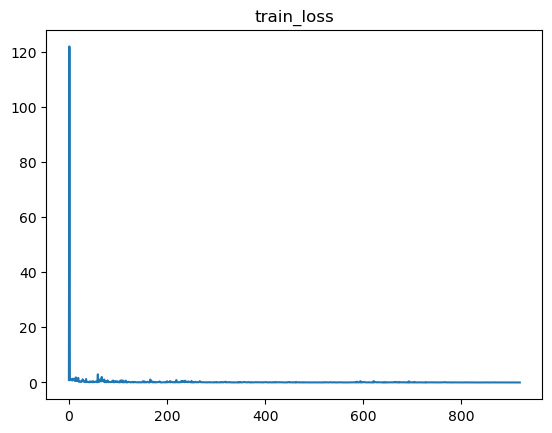

In [9]:
plt.plot(train_loss[:])
plt.title("train_loss")
train_loss[-1]

In [10]:
inputs = torch.tensor(test_inputs[:1000], dtype=torch.float)
preds1 = net(inputs.cuda()).detach().cpu().numpy()
inputs = torch.tensor(test_inputs[1000:], dtype=torch.float)
preds2 = net(inputs.cuda()).detach().cpu().numpy()
preds = np.concatenate((preds1, preds2), axis=0)

preds = preds * l_std + l_mean
test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)